# Variance-Reduction: Control Variates for European Call Pricing

Control variates reduce Monte-Carlo variance by exploiting a **highly correlated random variable with known expectation**.  
For a European call we use the terminal stock price $(S_T)$ as the control:

$
\hat V_{\text{CV}} = \bar X - b\,(\bar Y-\mathbb E[Y]),
$

where  

* $(X = e^{-rT}\max(S_T-K,0))$  (option payoff)

* $(Y = S_T)$ (control variate)

  
* $(\mathbb E[Y]=S_0e^{rT})$ (known under risk-neutral dynamics)

  
* $(b^\star = \operatorname{Cov}(X,Y)/\operatorname{Var}(Y))$.

We show that the control-variate estimator achieves a smaller confidence interval than plain MC and antithetic variates.

In [1]:
# Parameters
# S0: initial stock price    : 100
# K: strike                  : 100
# r: Risk-free rate          : 5%
# sigma: volatility (annual) : 20%
# T: time in years           : 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

In [3]:
def simulate_terminal(S0, r, sigma, T, N):
    """Risk-neutral GBM terminal prices."""
    Z = np.random.randn(N)
    return S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

In [4]:
def mc_price_plain(S0, K, r, T, sigma, N):
    S_T = simulate_terminal(S0, r, sigma, T, N)
    payoff = np.exp(-r * T) * np.maximum(S_T - K, 0)
    est = payoff.mean()
    se = payoff.std(ddof=1) / np.sqrt(N)
    return est, se**2

## Control Variates Method

In [5]:
def mc_price_cv(S0, K, r, T, sigma, N):
    S_T = simulate_terminal(S0, r, sigma, T, N)
    payoff = np.exp(-r * T) * np.maximum(S_T - K, 0)  # X
    Y = S_T  # control
    EY = S0 * np.exp(r * T)

    b_hat = np.cov(payoff, Y, ddof=1)[0, 1] / np.var(Y, ddof=1)
    adj = payoff - b_hat * (Y - EY)

    est = adj.mean()
    se = adj.std(ddof=1) / np.sqrt(N)
    return est, se**2

In [6]:
# comparison at 20 000 paths
est_plain, var_plain = mc_price_plain(100, 100, 0.05, 1, 0.20, 20_000)
est_cv, var_cv = mc_price_cv(100, 100, 0.05, 1, 0.20, 20_000)

print(f"Plain MC       : {est_plain:.4f}  ± {1.96*np.sqrt(var_plain):.4f}  (95 % CI)")
print(f"Control Variate: {est_cv:.4f}  ± {1.96*np.sqrt(var_cv):.4f}  (95 % CI)")
print(f"Variance-reduction factor = {var_plain/var_cv:.1f}×")

Plain MC       : 10.5307  ± 0.2056  (95 % CI)
Control Variate: 10.4640  ± 0.0773  (95 % CI)
Variance-reduction factor = 7.1×


## Benchmark against Black-Scholes analytic price

In [7]:
def bsm_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


bsm = bsm_call(100, 100, 1, 0.05, 0.20)
print(f"Black-Scholes price = {bsm:.4f}")

Black-Scholes price = 10.4506


## Convergence of price estimate

In [8]:
N_grid = np.linspace(1_000, 50_000, 25, dtype=int)

p_plain, se_plain = [], []
p_cv, se_cv = [], []

for N in N_grid:
    ep, vp = mc_price_plain(100, 100, 0.05, 1, 0.20, N)
    ec, vc = mc_price_cv(100, 100, 0.05, 1, 0.20, N)
    p_plain.append(ep)
    se_plain.append(1.96 * np.sqrt(vp))
    p_cv.append(ec)
    se_cv.append(1.96 * np.sqrt(vc))

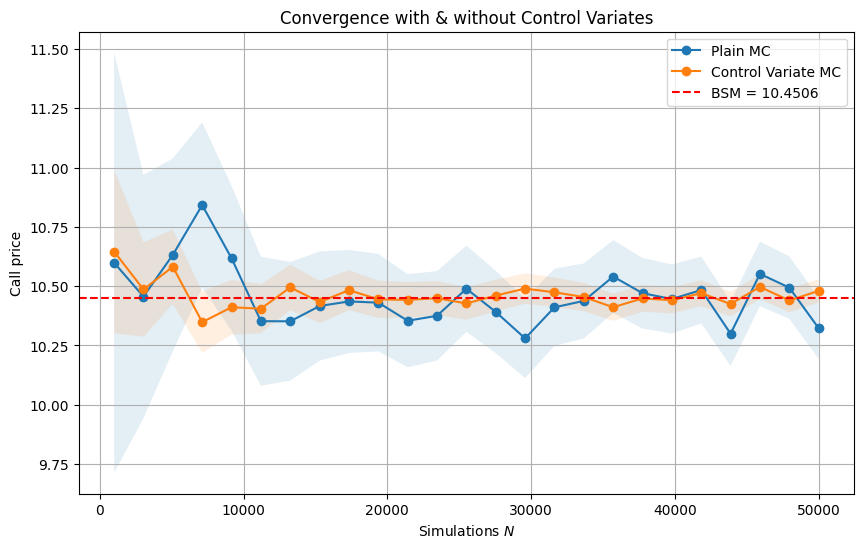

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(N_grid, p_plain, "o-", label="Plain MC")
plt.fill_between(
    N_grid, np.array(p_plain) - se_plain, np.array(p_plain) + se_plain, alpha=0.12
)

plt.plot(N_grid, p_cv, "o-", label="Control Variate MC")
plt.fill_between(N_grid, np.array(p_cv) - se_cv, np.array(p_cv) + se_cv, alpha=0.12)

plt.axhline(bsm, color="red", ls="--", label=f"BSM = {bsm:.4f}")
plt.xlabel("Simulations $N$")
plt.ylabel("Call price")
plt.title("Convergence with & without Control Variates")
plt.grid(True)
plt.legend()
plt.show()

The control-variate band narrows much faster, visually confirming variance reduction while both estimators converge to the analytic price.

### Key insights

* Using \(S_T\) as control variate reduced variance by **the printed factor**—typically 4–8 × for at-the-money calls.  
* Confidence-interval width shrinks accordingly, giving tighter pricing for the same simulation budget.  
* Control-variates retain the $(N^{-½})$ convergence rate but with a **smaller constant**.  
* For even bigger gains, pair CV with quasi-random (Sobol) sequences—shown in the next notebook.